# Project 1: Regression and Model Selection

In this project, you will construct a (linear) regression model, and apply it to a synthetic task as well as a real-world house value prediction task.

## Objectives
Your goal in this project is to get comfortable in implementing a complete supervised learning pipeline (in Python). To complete this project, you should understand the following:

* How to use basic math and machine learning modules in python such as numpy, matplotlib, and sklearn (*_You are encouraged to use numpy to vectorize array operations [see link](https://numpy.org/doc/stable//user/absolute_beginners.html#basic-array-operations)_*)
* How to train a regression model *from scratch*
* How to implement the *gradient descent* algorithm for iterative model update
* How to perform model section when facing multiple choices
* How to evaluate the test results and visualize the outcome of an ML model

## Deliverable
* Project report/writeup: A `project1_report_lastname.pdf` file with corresponding plots and results for the project. Follow the `Project 1 - Report (Individual Submission)` link on Gradescope to upload this file. The project report should include a brief justification of your solution at a high-level, e.g., using any relevant explanations, equations, or pictures that help to explain your solution. You should also describe what your code does, e.g. using a couple of sentences per function to describe your code structure. 

* Source code: A `project1_src_lastname1[_lastname2].ipynb` (or `.zip`) file with a working copy of your solutions compiled in a Jupyter notebook. Follow the `Project 1 - Source Code (Group Submission)` link to upload this file.


## Logistics

* You can work in groups of 1-2 students for each course project, and it's your responsibility to find a group (e.g. use Ed Discussion). 
* Every member of a group must complete and submit the project report/writeup individually. While the source code can be the same for all group members, the project report needs to be written independently by each person and, thus, should differ among team member and students more generally.
* One one group member need to submit the source code. If you submit as a group, make sure to include your teammate in the group submission. Instructions for team submission can be found [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
* Grades will be provided based on the individual project report. The source code submission will not be graded, but the teaching staff may check the source files if they see the need for reproducing your results when going through your project report. 
* Failure to submit the source code will lead to a deduction of points from your total.


## Task 1A: (Warmup) Linear Regression on Synthetic Dataset, *from Scratch*

### Loading math, machine learning, and visualization modules
We start importing some modules and running some magic commands

In [1]:
%matplotlib inline

# General math and plotting modules.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Machine Learning library. 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Utility/helper functions for generating synthetic dataset, plots, etc.

Below are a few utility functions for generating plots (you don't have to modify these functions).

In [2]:
def generate_polynomial_data(num_points, noise, w):
    dim = w.size - 1
    # Generate feature vector 
    
    # We often use np.random.seed for repeatability; 
    # remove it if you want to inject randomness into your results 
    np.random.seed(42)

    x = np.random.normal(size=(num_points, 1))
    x1 = np.power(x, 0)
    for d in range(dim):
        x1 = np.concatenate((np.power(x, 1 + d), x1), axis=1)  # X = [x, 1].
    y = np.dot(x1, w) + np.random.normal(size=(num_points,)) * noise  # y = Xw + eps

    return x1, y

def plot_data(X, Y, fig=None, options=dict()):
    if fig is None:
        fig = plt.subplot(111)
    fig.plot(X, Y, options.get('marker', 'b*'), 
        label=options.get('label', 'Raw data'),
        fillstyle=options.get('fillstyle', 'full'),
        ms=options.get('size', 8))
    process_plot(fig, options)

def plot_fit(X, w, fig=None, options=dict()):
    if fig is None:
        fig = plt.subplot(111)

    x_min = np.min(X[:, -2])
    x_max = np.max(X[:, -2])
    dim = w.size - 1
    x_plot = np.reshape(np.linspace(x_min, x_max, 100), [-1, 1])
    x1_plot = np.ones_like(x_plot)
    for d in range(dim):
        x1_plot = np.concatenate((np.power(x_plot, 1 + d), x1_plot), axis=1)

    y_plot = np.dot(x1_plot, w)
    fig.plot(x_plot, y_plot, 'r-', label=options.get('label', 'Regression fit'))
    process_plot(fig, options)

def process_plot(fig, options=dict()):
    if 'x_label' in options.keys():
        fig.set_xlabel(options['x_label'])
    if 'y_label' in options.keys():
        fig.set_ylabel(options['y_label'])
    if 'x_lim' in options.keys():
        fig.set_ylim(options['x_lim'])
    if 'y_lim' in options.keys():
        fig.set_ylim(options['y_lim'])
    if 'title' in options.keys():
        fig.set_title(options['title'])
    if 'legend' in options.keys():
        if options['legend']:
            fig.legend(loc=options.get('legend_loc', 'best'))

### Data loader

Loading and processing dataset (you don't have to modify these functions).

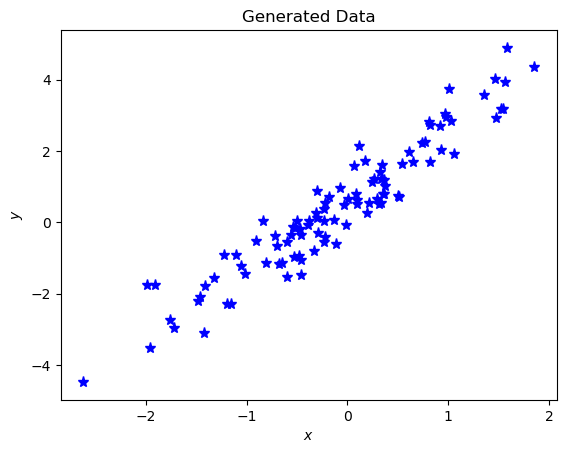

In [3]:
# Generate the data.
num_points = 100  # Number of training points.
noise = 0.6  # Noise Level (needed for data generation).

w_true = np.array([2, 0.6]) # groundtruth function parameter

X, y = generate_polynomial_data(num_points, noise, w_true) # y = X w_true + noise

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

# Plot Data
fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Generated Data', 'y_lim': [np.min(y)-0.5, np.max(y)+0.5]}
plot_data(X[:, 0], y, fig=fig, options=plot_opts)

### Modeling (30pt)

In the following, you will write you own loss function for this linear regression task. This could be later used for the regression applications in Task 1B.


### The key ingredient of modeling: risk (i.e. expected loss) function and its gradient

We will start by fitting by linear regression a set of data points of the type $D = \left\{(\mathbf{x}, y)_i\right\}$, $i \in \{1, 2, \ldots, n\}$.

The objective of linear regression, is to find coefficents $\hat{w}$ such that the residual between $\hat{y} = \hat{\mathbf{w}}^\top \tilde{\mathbf{x}}$, and $y$ is small. (Remember that $\tilde{\mathbf{x}} = [\mathbf{x}, 1]$). From now on, $\mathbf{x}$ will be considered the extended version unless stated otherwise, hence dropping the tilde notation. 

We consider the ridge regression risk function, defined as 
$$ R({\mathbf{w}}) = \mathbb{E}[(y-{\mathbf{w}}^\top x)^2)] +  \lambda \mathbf{w}^\top \mathbf{w}$$

where the expectation is taken over the data generating the distribution of points. As the whole data generating distribution is not known, the expectation is approximated by samples from the **training** set. 

The risk is approximated by the *empirical risk* as:


$$\hat{R}_{\text{ridge}}(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n \left(y_i - \mathbf{w}^\top \mathbf{x}_i\right)^2 + \lambda \mathbf{w}^\top \mathbf{w}$$

In the following, construct a customized funciton which returns the empirical risk and its gradient at parameter $\theta$:

In [4]:
# Constructing the empirical risk function for ridge regression.
def lossFunction(theta, X, y ,Lambda):
    """
    Take in numpy array of theta, X, and y to return the regularize loss function and gradient
    of a logistic regression
    """
    # initialize regularized average loss (empirical risk) and its gradient
    regLoss = 0
    grad = np.zeros(theta.shape)
    n = len(y)
    
    for i in range(n):
        regLoss += (y[i] - theta.T@X[i])**2
        
    regLoss *= 1/n
    regLoss += Lambda*(theta.T@theta).item() 
    
    y = y.reshape(-1,1)
    
    grad = -2/n*(X.T@(y-X@theta)) + 2*Lambda*theta
    
    return regLoss, grad

# Initialize fitting parameters
initial_theta = np.zeros((X.shape[1], 1))

# Set regularization parameter lambda
Lambda = 0.1

#Compute and display initial loss and gradient for regularized logistic regression
emp_risk, grad=lossFunction(initial_theta, X, y, Lambda)
print("Loss at initial theta (zeros):",emp_risk)
print(grad)

Loss at initial theta (zeros): [3.47407884]
[[-3.04146267]
 [-0.81137943]]


### Training your ridge regressor: Gradient descent (15pt)

There are many algorithmic tools for training your classifier. Here, we use the popular gradient descent algorithm:

The parameters $\hat{\mathbf{w}}$ can be updated via a gradient descent rule: 

$$ \hat{\mathbf{w}}_{k+1} \gets \hat{\mathbf{w}}_k - \eta_k \left.\frac{\partial \hat{R}}{\partial \mathbf{w}} \right|_{\mathbf{w}=\mathbf{w}_k},$$

where $\eta_k$ is a parameter of the algorithm, $k$ is the iteration index, and $\frac{\partial \hat{R}}{\partial \mathbf{w}}$ is the gradient of the empirical risk function w.r.t. $\mathbf{w}$.

In the *vanilla* gradient descent method, $\eta(k)=\eta_0$ is a constant. However other algorithms exists that modify this.

The computational complexity of Gradient descent is $O(n_{\text{iter}} \cdot  n d)$. 


Write a customized function `gradientDescent(X,y,theta,eta,Lambda,tolerance)`
 which returns an array of empirical risk values, one for each iteration, as well as the final output of the model parameter. 
 
 Here, `tolerance` specifies the stopping condition: The gradient descent algorithm terminates the observed loss values converges (i.e. two consective losses differ by at most `tolerance`). Hint: the loss should be descending in the loss plot.

4.01182439041515
3.87687302308134
3.7474909408101165
3.623446182632781
3.504516544647982
3.390489165315663
3.2811601285674317
3.1763340839595866
3.0758238831290328
2.9794502318447234
2.8870413569783393
2.798432687747513
2.7134665506132953
2.631991877240568
2.553863924956055
2.47894400916328
2.40709924719746
2.338202313125944
2.272131203021386
2.208769010255486
2.148003710380877
2.0897279551876102
2.033838875538671
1.9802378926062665
1.9288305371470609
1.87952627647028
1.8322383487677036
1.7868836044889305
1.7433823544590648
1.701658224449163
1.6616380159223247
1.6232515726903571
1.5864316532274498
1.5511138083982796
1.5172362643684976
1.4847398104755745
1.4535676918476392
1.4236655065670896
1.3949811071845866
1.367464506397418
1.3410677867142846
1.3157450139362148
1.2914521542907114
1.2681469950632154
1.2457890685767414
1.2243395793769314
1.2037613344859561
1.1840186765945577
1.1650774200671556
1.1469047896403342
1.1294693617001523
1.1127410080286664
1.0966908419147499
1.08129116652880

Text(0.5, 1.0, 'Loss function using Gradient Descent')

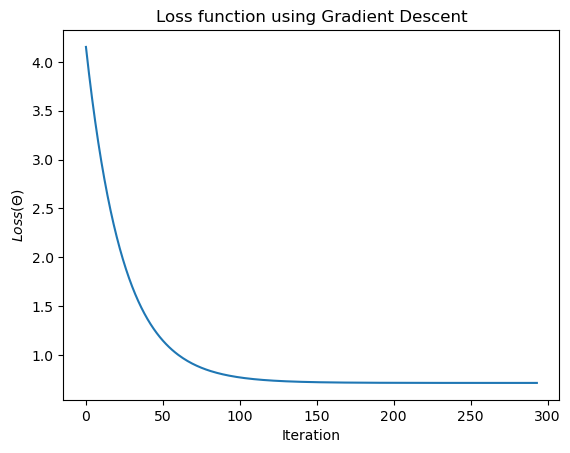

In [5]:
def gradientDescent(X,y,theta,eta,Lambda,tolerance):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of eta
    
    return theta and the list of the loss of theta during each iteration
    """
    Loss_history =[]
    
    init_risk, init_grad = lossFunction(theta, X, y, Lambda)
    Loss_history.append(init_risk[0])
    theta = theta - eta*init_grad
    
    while True:
        risk, grad = lossFunction(theta, X, y, Lambda)
        Loss_history.append(risk[0])
        print(risk[0])
        if np.abs(Loss_history[-2] - Loss_history[-1]) < tolerance:
            break
        theta = theta - eta*grad
        
    return theta, Loss_history

Eta = 0.01
Tolerance = 1e-6

theta, Loss_history = gradientDescent(X_train,y_train,initial_theta,Eta,Lambda,Tolerance)
print("The regularized theta using ridge regression:\n",theta)
# print(Loss_history)
plt.plot(Loss_history)
plt.xlabel("Iteration")
plt.ylabel("$Loss(\Theta)$")
plt.title("Loss function using Gradient Descent")


### Test module (5pt)

We still need a method to evaluate the model constructed. Here, we plot the predicted values on the test data, together with the training points.

Let's take a look at the final results.


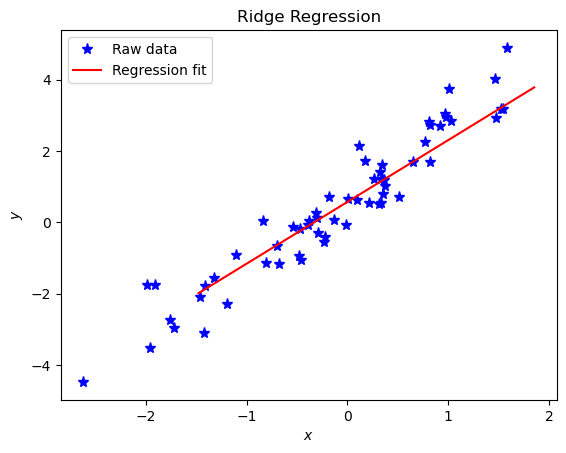

In [6]:
# Plot predicted function
fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Ridge Regression', 'legend': True,
                 'y_lim': [np.min(y)-0.5, np.max(y)+0.5]}

plot_data(X_train[:,0], y_train, fig=fig, options=plot_opts)
plot_fit(X_test, theta, fig=fig, options=plot_opts)


## Task 1B: Real Dataset: House Value Prediction

We will use the [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from the scikit-learn package. The task is to predict the house values in California districts given some summary stats about them based on the 1990 census data.

The dataset has 8 features: longitudes, latitudes, housing median age, total rooms, total bedrooms, population, households, median income, and median house value. The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($\$100,000$). We split the dataset as 80\% for training data and 20\% for testing data. 

The following script loads the dataset (using pandas dataframe):

In [7]:
# python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import pandas as pd

california=fetch_california_housing()
california_df=pd.DataFrame(california.data,columns=california.feature_names)
california_df['Price']=california.target
california_df 

newX=california_df.drop('Price',axis=1)
newY=california_df['Price']

newX = StandardScaler().fit_transform(newX)


Following the script below, you will be able to generate the training and test data.

In [8]:
N_train = len(newX) * .8

np.random.seed(150)
msk = np.random.rand(len(newX)) < 0.8

X_train, y_train = newX[msk], newY[msk]
X_test, y_test = newX[~msk], newY[~msk]
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
print(X_test.shape)
print(X_train.shape)
print(y_train.shape)

(4081, 8)
(16559, 8)
(16559,)


### Training and evaluation (25pt)

Write a function to fit the Ridge regression on the training data and calculate the MSE on the training set. Choosing $\lambda$ from $\{10^{-10}, 10^{-6}, 10^{-4}, 10^{-2}, 10^{-1}, 1, 10, 20, 50, 100\}$, compute the estimate $\hat{\mathbf{y}}$ for different values $\lambda$, and plot the test MSE as a function of $\lambda$. 


❗**Note**: You should write your own model fitting and prediction (following the ones you construct in Task 1A). You may call your customized function `lossFunction` and `gradientDescent`. Do not use `sklearn.linear_model` module (i.e. for model fitting and making predictions).

5.603867071779787
5.601025939739538
5.598197139178348
5.595380612529994
5.592576302517418
5.589784152151557
5.587004104729432
5.584236103832723
5.581480093326291
5.578736017356522
5.576003820349848
5.573283447011251
5.570574842322746
5.5678779515417585
5.565192720199855
5.562519094101113
5.5598570193205035
5.557206442202857
5.554567309360941
5.551939567674258
5.549323164287644
5.54671804660952
5.544124162310966
5.541541459323733
5.538969885839391
5.53640939030753
5.533859921434482
5.531321428182045
5.528793859765894
5.52627716565451
5.523771295567554
5.521276199474564
5.518791827593745
5.516318130390481
5.513855058576125
5.511402563106544
5.508960595180987
5.506529106240527
5.5041080479671445
5.50169737228196
5.4992970313443585
5.49690697755039
5.4945271635319255
5.4921575421547955
5.4897980665181825
5.4874486899528625
5.48510936602016
5.482780048510975
5.480460691444039
5.478151249064969
5.475851675845318
5.4735619264807145
5.471281955890386
5.469011719215522
5.46675117181822
5.464500

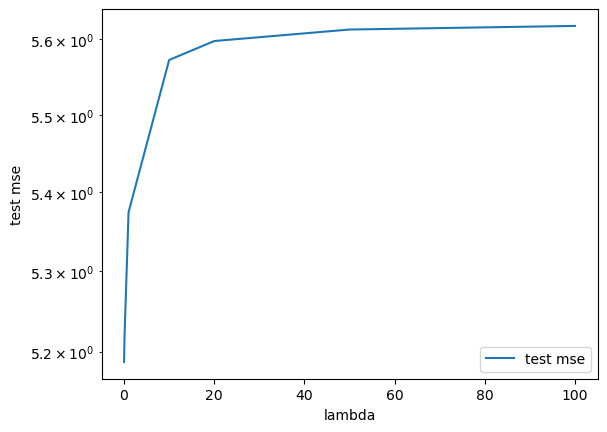

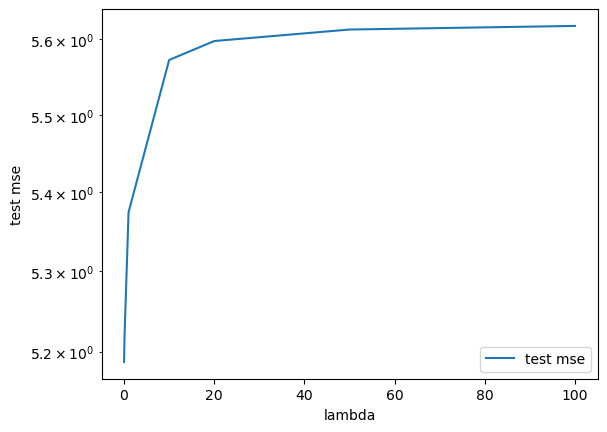

In [9]:
def train_and_eval( X_train , y_train , X_eval , y_eval , lambda_ ):
    mse = 0
    initial_theta = np.zeros((X_train.shape[1], 1))
    Eta = 1e-3
    Tolerance = 1e-3

    theta, _ = gradientDescent(X_train,y_train,initial_theta,Eta,lambda_,Tolerance)
    
    for i in range(len(y_eval)):
        mse += ((y_eval[i] - theta.flatten().T@X_eval[i]))**2
    return mse/len(y_eval)
    

weight_list = [1e-10, 1e-6, 1e-4, 0.01, 0.1, 1, 10, 20, 50, 100]
result_list = []

# compute test MSE
for weight in weight_list:
    test_mse = train_and_eval(X_train , y_train , X_test , y_test , weight)
    result_list.append([test_mse, weight])
    result_array = np.array (result_list)
    
plt.figure()
plt.plot( result_array [: , -1] , result_array [: ,0] , label = 'test mse')
plt.xlabel('lambda')
plt.ylabel('test mse')
plt.yscale('log')
plt.legend()
plt.show()

### Model selection via k-fold cross validation (25pt)

Implement *10-fold cross validation* on the training set to select $\lambda$. 

Plot and compare the MSE on the hold-out set with the true MSE which is computed on the test set. And see how we get to finding the ``best'' $\lambda$.

❗**Note:** For this subproblem, you should write your own function for cross validation; in particular, you should **not** call the existing `sklearn.model_selection` module.

In [10]:
def cross_validation(X_train, y_train, lambda_, k=10):
    """
    Perform k-fold cross validation on X_train and y_train.
    """
    sample_count, feature_count = X_train.shape
    subset_size = sample_count // k
    X_train = X_train[:subset_size*k, :]
    y_train = y_train[:subset_size*k]
    X_train = X_train.reshape(k, subset_size, feature_count)
    y_train = y_train.reshape(k, subset_size)
    subset_idcs = np.arange(k)
    train_set_size = (k - 1) * subset_size
    mses = []
    
    for i in subset_idcs:
        Xh = X_train[i]
        yh = y_train[i]
        new_ids = np.delete(subset_idcs, i)
        
        Xt = X_train[new_ids].reshape(train_set_size, feature_count)
        yt = y_train[new_ids].reshape(train_set_size)
        
        res = train_and_eval(Xt, yt, Xh, yh, lambda_)
        mses.append(res)

    return sum(mses)/len(mses)


# List of lambdas to try
weight_list = [1e-10, 1e-6, 1e-4, 0.01, 0.1, 1, 10, 20, 50, 100]

best_lambda = None
best_mse = np.inf

# Find the best lambda
for lambda_ in weight_list:
    print("cross validation with lambda: ", lambda_)
    mse = cross_validation(X_train, y_train, lambda_)
    print('mse',mse)
    if mse < best_mse:
        best_mse = mse
        best_lambda = lambda_

print("Best lambda: ", best_lambda)


cross validation with lambda:  1e-10
5.718047398483112
5.714487513911638
5.710945484191113
5.707421210688819
5.703914595361838
5.7004255407529945
5.696953949987177
5.693499726767827
5.690062775373047
5.686643000651986
5.683240308021336
5.679854603461416
5.6764857935131
5.67313378527367
5.669798486393629
5.666479805073182
5.663177650058598
5.6598919306388265
5.656622556642074
5.653369438432309
5.650132486906003
5.646911613488537
5.643706730130956
5.640517749306828
5.637344584008503
5.634187147744271
5.6310453545349155
5.627919118910297
5.624808355906388
5.621712981062002
5.618632910415533
5.615568060501921
5.612518348349388
5.609483691476404
5.6064640078885475
5.603459216075512
5.600469235007981
5.597493984134518
5.594533383378706
5.591587353136057
5.588655814271208
5.585738688114548
5.582835896459807
5.579947361560852
5.577073006128625
5.574212753328856
5.571366526778478
5.568534250543321
5.565715849134913
5.562911247508183
5.5601203710580895
5.557343145617197
5.554579497452919
5.55182

6.058233140779626
6.008370995275362
6.065506742224707
5.9997781205021266
6.072778530634712
5.991188204010592
6.080048505792043
5.982601244945643
6.087316667480064
5.975142649471138
6.093450095677836
5.981111495353324
6.086161830101295
5.9870774906972715
6.078877558963687
5.9930406367443645
6.071597279953824
5.999000934735562
6.06432099076205
6.004958385911225
6.057048689080055
6.010912991511334
6.0589178364105
6.007717515962355
6.0652822290315695
6.0002251169708645
6.0714391830909555
5.995047042852183
6.0752977108144135
5.989871445198498
6.079154904790922
5.9846983227529895
6.083010765209415
5.98369696485823
6.082704813735286
5.992178003791723
6.072905819343505
6.000655552891784
6.063111457392126
6.0091296136786765
6.053321725292318
6.0185224091497735
6.04260776668251
6.02929679392149
6.034106989648505
6.036506294159715
6.039434098379754
6.029865907581626
6.04558784705789
6.022953030492554
6.051176286232109
6.016233708047129
6.056573654529135
6.009518571479427
6.0619679821626775
6.0028

5.520722488991196
5.515940773047975
5.5262058665778815
5.514999993715135
5.5262095671920335
5.520011425881677
5.521024505473502
5.524257097288322
5.516907272585953
5.527444151833641
5.5127914719268905
5.530630548558434
5.508677103121299
5.5338162871426455
5.504564165794171
5.537001367266923
5.500452659570663
5.540185788612462
5.507464165175862
5.532249737989288
5.5147726966745845
5.524013277349286
5.522077875495576
5.515780942827222
5.529379703396586
5.507552731970719
5.536678182134536
5.499328642329078
5.54397331346522
5.49110867145323
5.551265099143449
5.488220838765863
5.553221360032966
5.491420364073477
5.549092803187645
5.496200843014653
5.543382028548022
5.502169046990083
5.536485305669754
5.508134514098577
5.529592094641258
5.514097245454011
5.52270239365141
5.520057242169967
5.515816200890276
5.526014505359438
5.519922299203806
5.520971726621923
5.524455509947909
5.51550874044299
5.528987443170112
5.510047807602766
5.5335180991958595
5.504588927078005
5.538047478350617
5.499132

5.700949469434245
5.639722582266063
5.707164286695435
5.6323159566466545
5.713377628400275
5.624911891921447
5.719589494361131
5.617510387217875
5.7257998843914075
5.610111441663743
5.732008798305065
5.608976289021191
5.731954598548561
5.614687151125544
5.7250529530374346
5.620394732107323
5.7181556726493845
5.626099033856717
5.71126275443573
5.631800058263
5.704374195449767
5.637497807214197
5.697489992747184
5.6431922825971235
5.70204794702661
5.63744316710765
5.708525479466484
5.629768686813631
5.717971953329494
5.621165909282358
5.72539605176881
5.612958027753248
5.732409711568986
5.604754438239954
5.739420166318136
5.6001015519055475
5.7428725620905485
5.605011472978907
5.736768755855948
5.610628823231154
5.72994306198084
5.61627184056427
5.723108487204687
5.621913639532873
5.716276216122113
5.627554220218346
5.709446247590976
5.633193582702235
5.711402966104797
5.630051944748682
5.717691310487176
5.62257224387729
5.723976112487436
5.61509717070343
5.730257373729375
5.608174684684

5.319832552619708
5.284374981093901
5.328021220810273
5.27513943333726
5.33776157857749
5.264333729302216
5.348489447136894
5.254059758029442
5.35929345981535
5.245435032607942
5.366845486074877
5.237871573206131
5.373331038580192
5.23915183764867
5.370978347361801
5.24043140357359
5.368627592125071
5.241710271356021
5.3662787708779955
5.242988441371339
5.363931881631026
5.244265913994949
5.3615869223965635
5.245542689602432
5.359243891189305
5.246818768569472
5.356902786025977
5.250642018366243
5.357250458607754
5.254958280204801
5.356549882703673
5.254586187783788
5.355851644577717
5.254212993963765
5.355155741246536
5.253838700114617
5.354462169730046
5.253463307605447
5.353770927051361
5.253086817804278
5.353717046407323
5.252058790701981
5.357805572998698
5.246902832776314
5.361892125156169
5.2510803613808115
5.356638525911653
5.255814552725804
5.350835194671095
5.260547556647574
5.345034283732968
5.265279373146497
5.339235791486974
5.270010002223857
5.339224382083482
5.2689641503

6.743482002683351
7.006905095671874
6.7401575001071325
7.008910753758011
6.736836098189715
7.010914452407819
6.733517794565216
7.01291619292213
6.730202586869422
7.0149159766013325
6.726890472740204
7.016913804744907
6.723581449816956
7.0189096786514735
6.720275515741359
7.020903599619004
6.716972668156438
7.022895568944623
6.74329189145407
6.995296613148417
6.774096457236595
6.963176008820821
6.804889230232561
6.931068339322716
6.835670214999605
6.8989735990289365
6.866439416094147
6.8668917823169116
5.453938640436913
7.424521933948361
5.483010878637118
7.394121938127442
5.512068879923739
7.363737390956306
5.54111265167424
7.333368283848783
5.570142201261968
7.303014608224181
5.599157536056215
7.272676355507141
5.6281586634220515
7.242353517127835
5.657145590720565
7.212046084521875
5.686118325308745
7.181754049130282
5.715076874539283
7.1514774023994745
5.744021245761111
7.121216135781367
5.772951446318678
7.090970240733158
5.80186748355254
7.06073970871765
5.830769364799323
7.030524

7.268979077843197
6.0861582087203425
7.273425488325415
6.080429246729471
7.2778689037097894
6.074704480639427
7.282309325631291
6.0689839075884064
7.2867467557240175
6.06326752471688
7.291181195621579
6.05755532916715
7.2956126469566875
6.051847318084005
7.300041111361436
6.046143488613811
7.304466590467254
6.04044383790535
7.308889085904667
6.03474836310946
7.313308599303752
6.029057061378879
7.3177251322936225
6.023369929868524
7.322138686502823
6.038072612319018
7.306192862997285
6.065852408283595
7.277134381288693
6.093621375735663
7.248087926571534
6.121379518952137
7.21905349334517
6.149126842208364
7.190031076111714
6.176863349778204
7.161020669376322
6.204589045933879
7.132022267646988
6.232303934946046
7.103035865434677
6.260008021084019
7.074061457253121
6.287701308615396
7.045099037619115
6.315383801806224
7.01614860105217
6.343055504921184
6.987210142074829
6.370716422223227
6.958283655212518
6.398366557973834
6.929369134993444
6.426005916433003
6.905536613771638
6.44852772

6.728985717864657
6.63714567761441
6.7001678417637
6.664676634496497
6.671361893232011
6.6921968683656
6.642567866803241
6.719706383454838
6.6137857570140755
6.747205183996062
6.585015558404122
6.774693274219372
6.556257265515598
6.802170658353621
6.527510872894055
6.8296373406258315
6.49877637508757
6.857093325261676
6.496557944351843
6.857997692962076
6.501233013795483
6.8520390033811465
6.505904970564432
6.846084630681188
6.510573816355372
6.840134571932132
6.515239552864097
6.834188824206185
6.519902181785865
6.828247384577671
6.5245617048149995
6.822310250122868
6.529218123645341
6.816377417920351
6.533871439969622
6.810448885050764
6.538521655480159
6.804524648596805
6.543168771868327
6.7986047056434264
6.547812790824861
6.792689053277527
6.552453714039641
6.7867776885882645
6.557091543201955
6.780870608666728
6.5617262800002765
6.786089614439504
6.555265367496829
6.813631703176626
6.526445827492312
6.8411630745138305
6.4976382043336525
6.868683732673938
6.468842492570542
6.89619

6.7374700218307755
6.616221465323304
6.727377076634805
6.625034349097603
6.717288314556527
6.63384424788715
6.707203734768166
6.642651161294235
6.697123336441772
6.651455088922926
6.687047118748896
6.660256030378855
6.708708713991178
6.637343394689421
6.732084839342732
6.612686901341995
6.755450133065966
6.58804244109206
6.77880460147184
6.563410006398666
6.802148250867386
6.5387895897265285
6.825481087555674
6.514181183545363
6.8488031178357165
6.489584780330495
6.872114348002702
6.465000372562369
6.895414784347749
6.440427952726945
6.918704433158116
6.415867513315327
6.941983300717101
6.391319046824087
6.965251393303939
6.366782545755044
6.988508717194073
6.342258002615255
7.011755278658854
6.317745409917243
7.034991083965783
6.309544058523888
7.041886303493169
6.3184347343030725
7.031713726521248
6.327322385712586
7.021545375234323
6.336207012377735
7.0113812487796805
6.345088613925718
7.0012213463042645
6.353967189985346
6.991065666954676
6.362842740187154
5.373631791144011
7.34739

6.669483456308884
6.461715415128634
6.649557946975561
6.480562148983017
6.629641407603597
6.499400805558646
6.609733833697817
6.5182313885389425
6.589835220765437
6.537053901605527
6.573974999281587
6.551919028187142
6.564056253552165
6.5607610991696275
6.564536697762348
6.559156527687756
6.583054823521394
6.539557718054352
6.601565509790284
6.519967247505972
6.62006876053074
6.500385111257742
6.638564579701623
6.480811304528081
6.657052971259738
6.461245822538663
6.675533939159025
6.4416886605144565
6.694007487351241
6.422139813683715
6.712473619785578
6.402599277278003
6.730932340408778
6.3830670465322425
6.749383653165204
6.363543116684517
6.767827561996572
6.34402748297624
6.786264070842342
6.324520140652112
6.804693183639518
6.305021084960074
6.82311490432242
6.285530311151465
6.841529236823129
6.2660478144807445
6.859936185071251
6.24657359020579
6.878335752993965
6.2358624355525345
6.888015699837344
6.244917368680296
6.877882119752402
6.253968964430864
6.867752774061021
6.263017

6.514009768340506
6.615051969876494
6.5004372404196635
6.627544896297707
6.486872386374804
6.64003104502593
6.473315201595058
6.65251041985357
6.459765681472545
6.664983024570587
6.446223821402501
6.67744886296468
6.432689616783319
6.689907938821427
6.419163063016488
6.702360255924068
6.423485767354943
6.69697746681287
6.438438572161746
6.68094643577052
6.453387432781516
6.664920245952492
6.468332349566742
6.6488988961864175
6.483273322870784
6.632882385300147
6.4982103530477255
6.6168707121213775
6.513143440452691
6.600863875477729
6.528072585441487
6.584861874196818
6.542997788370994
6.56886470710633
6.557919049598691
6.5528723730338445
6.57283636948305
6.53688487080686
6.5877497483834
6.520902199252893
6.602659186659912
6.504924357199485
6.617564684673533
6.488951343474089
6.632466242786059
6.472983156904123
6.64736386136028
6.457019796316962
6.6622575407596925
6.441061260540101
6.677147281348628
6.4408209900421705
6.676300596271108
6.453297080640509
6.662751691302786
6.465766446226

6.611156346334684
6.4198578644847935
6.590932513766887
6.438889389782899
6.570713642490872
6.45791703623202
6.550499732330773
6.47694080295188
6.5302907831096455
6.495960689064751
6.51008679464927
6.514976693694854
6.514086081507829
5.1607302842948855
7.127253915970687
5.194035300538211
7.092872079353627
5.227321950742834
7.058509856317956
5.260590245881319
7.02416723425808
5.293840196919297
6.989844200577517
5.327071814815394
6.955540742688981
5.360285110521444
6.921256848014456
5.393480094982421
6.8869925039851
5.426656779136374
6.852747698041261
5.4598151739144605
6.818522417632428
5.492955290241112
6.7843166502173435
5.526077139033682
6.750130383263846
5.559180731202871
6.715963604248958
5.592266077652477
6.681816300658769
5.62533318927935
6.647688459988602
5.6583820769735125
6.613580069742978
5.691412751618374
6.579491117435357
5.724425224090176
6.545421590588508
5.757419505258555
6.511371476734153
5.7903956059861725
6.477340763413198
5.823353537129108
6.463404350470995
5.83617499

6.716290104620502
6.982906031106813
6.700947555833371
6.996786699607442
6.6856108486933685
7.010662818291514
6.670279980555339
7.02453438856623
6.668795357855783
7.024543236244496
6.687907138072423
7.003967230057363
6.7070097756428915
6.983401663838333
6.727364209775448
6.961608853624308
6.7548445733282385
6.932667527703733
6.782314525725672
6.90373790545126
6.8097740705413035
6.874819982056024
6.837223211347834
6.845913752709612
6.86466195171735
6.82804342672938
6.880968363049002
6.811089097610334
6.8964549371660695
6.794140880888566
6.911936694178273
6.7771987752873954
6.92741363412253
6.760262779529431
6.942885757037115
6.74333289233744
6.958353062962036
6.739530473523441
6.960736726842009
6.757078204036917
6.941721535103179
6.774617023789611
6.922716552371716
6.792146938469941
6.903721771714896
6.809667953762598
6.884737186204934
6.827180075348617
6.8657627889191595
6.844683308905173
6.846798572940021
6.862177660105665
6.827844531354766
6.87966313461988
6.808900657255883
6.89713973

6.811766403084987
6.8953014377619315
6.796226079129329
6.909373687595491
6.780691720347954
6.923441268818738
6.7651633255033135
6.937504181427447
6.749640893357192
6.95156242541881
6.734124422671295
6.965616000791771
6.718613912206841
6.979664907546866
6.703109360724796
6.9937091456861715
6.6935740374096815
7.001828626821084
6.712570494211313
6.981366964377721
6.731557870286871
6.960915679721934
6.7505361713785685
6.940474765867756
6.769505403224952
6.920044215834148
6.788465571560658
6.899624022645229
6.807416682116598
6.87921417933021
6.826358740619889
6.8588146789233075
6.8452917527939094
6.83842551446387
6.86421572435817
6.818046678996118
6.883872590184172
6.796878814337617
6.912534327005603
6.766843762536711
6.942600510438818
6.73532381511035
6.972652150235228
6.703819698670385
7.002689254694809
6.677596212754106
7.027428267508729
6.680508533646124
7.023044034521666
6.683421717110517
7.01866024129329
6.6863357605357985
7.014276889187299
6.689250661313529
7.009893979565528
6.692166

8.19809874793407
11.249134545921077
8.235222353132071
11.210567475467926
8.272329037272652
11.172018781212216
8.309418806181661
11.13348845571613
8.346491665683727
11.094976491545117
8.383547621602448
11.056482881267549
8.42058667976022
11.01800761745503
8.457608845978308
10.979550692682075
8.494614126076698
10.941112099526329
8.531602525874375
10.902691830568514
8.56857405118921
10.864289878392526
8.605528707837824
10.825906235585062
8.642466501635724
10.787540894736072
8.679387438397221
10.749193848438527
8.716291523935558
10.710865089288447
8.753178764062799
10.67255460988485
8.790049164589782
10.634262402829982
8.826902731326346
10.595988460728893
8.863739470081018
10.557732776189846
8.900559386661193
10.519495341824182
8.93736248687317
10.481276150246224
8.97414877652221
10.443075194073275
9.010918261412009
10.404892465925851
9.047670947345594
10.366727958427337
9.084406840124515
10.328581664204211
9.121125945549252
10.290453575886108
9.157828269419154
10.252343686105599
9.1945138

8.820626227831632
10.617779264195487
8.831211586462512
10.605764403474835
8.84179979190062
10.593748128951582
8.852390837577165
10.581730445615108
8.86447172569193
10.567881692345217
8.908632741832431
10.522286396728404
8.952776100934916
10.476710207207176
8.996901811094945
10.43115311407622
9.0410098804044
10.38561510763557
9.085100316951642
10.340096178190828
9.129173128821279
10.294596316053127
9.173228324094527
10.249115511539186
9.217265910848964
10.20365375497098
9.261285897158618
10.15821103667632
9.305288291093929
10.112787346988124
9.349273100721753
10.067382676245138
9.393240334105272
10.021997014791367
9.437189999304307
9.97663035297642
9.481122104375093
9.931282681155343
9.525036657370018
9.88595398968874
9.568933666338175
9.840644268942507
9.612813139325045
9.795353509288155
9.656675084372498
9.801778346988167
9.648707876240193
9.820264552082337
9.628781765907526
9.838741927896187
9.608865932639791
9.857210477677054
9.58896037158836
9.875670204671453
9.572271583751181
9.89

12.812973704536923
6.977343181328088
12.748809716831378
7.040171097953849
12.684671310292234
7.102974583295133
12.620558474055116
7.165753647146658
12.5564711972604
7.228508299299447
12.492409469053445
7.291238549540685
12.428373278584575
7.3539444076537475
12.364362615008972
7.41662588341808
12.300377467486486
7.479282986609446
12.236417825182226
7.54191572699983
12.17248367726583
7.604524114357231
12.108575012911992
7.667108158445954
12.044691821300175
7.729667869026521
12.03001764015286
7.742877337187064
12.034314407410488
7.737244468439133
12.038606866730781
7.731617064434071
12.042895021152901
7.725995121053042
12.047178873713893
7.720378634180145
12.051458427448722
7.714767599702634
12.055733685390356
7.70916201351114
12.06000465056977
7.703561871499046
12.064271326015945
7.697967169563078
12.068533714755725
7.69237790360288
12.072791819813936
7.686794069521453
12.077045644213502
7.681215663224664
12.081295190975286
7.67564268062162
12.085540463118026
7.670075117624421
12.0897814

10.18996723492433
9.577785726663802
10.166032888294676
9.600393492587283
10.142106781447827
9.622994164350278
10.11818891266357
9.64558774260459
10.09427928022114
9.668174228003664
10.070377882399265
9.690753621202493
10.046484717476005
9.713325922857809
10.022599783728879
9.73589113362801
9.998723079434836
9.758449254172936
9.974854602870307
9.781000285154274
9.950994352311065
9.803544227235218
9.927142326032428
9.826081081080646
9.903298522309061
9.848610847357017
9.879462939415173
9.87113352673253
9.855635575624312
9.893649119876818
9.831816429209418
9.916157627461269
9.808005498443027
9.938659050158964
9.784202781597065
9.961153388644291
9.760408276942798
9.983640643593617
9.736621982751073
10.006120815684723
9.71284389729211
10.028593905597031
9.689074018835624
10.051059914011482
9.665312345650708
10.073947828308583
9.652497022128358
10.099654625380204
9.689021139253942
10.06179589039169
9.725536585223578
10.023946990842429
9.762043362255772
9.98610792341761
9.798541472568926
9.94

10.65522822781132
8.2333599933976
10.634677066008424
8.252586885338813
10.614132431353786
8.271808451526734
10.593594324033123
8.291024690581253
10.573062744229972
8.310235601125918
10.552537692125576
8.329441181787665
10.53201916789916
8.348641431197152
10.511507171727537
8.367836347988323
10.491001703785514
8.387025930798737
10.470502764245495
8.406210178269538
10.45001035327778
8.425389089045241
10.468531046377372
8.40565370014908
10.515009905805044
8.357849463675883
10.561466584333159
8.31006861562253
10.607901095019848
8.262311141729477
10.65431345091493
8.214577027746865
10.700703665059962
8.166866259434435
10.747071750487986
8.119178822561679
10.793417720223783
8.071514702907825
10.839741587283765
8.023873886261558
10.886043364675881
7.9762563584214625
10.932323065399858
7.9286621051956985
10.978580702447154
7.881091112401907
11.024816288800666
7.83354336586768
11.071029837435196
7.786018851430013
11.117221361316997
7.7385175549355765
11.16339087340428
7.691039462240676
11.20953

8.689807093293785
10.186283031792595
8.70886812217795
10.165899659796683
8.727923845710254
10.145522796549722
8.74697426252752
10.12515244221967
8.783734641492849
10.08697726850815
8.824550089680562
10.044836148723359
8.865344075690727
10.002717707681033
8.906116610071862
9.960621933611442
8.946867703366987
9.91854881475152
8.987597366113706
9.87649833934498
9.028305608844194
9.834470495642364
9.068992442085175
9.79246527190092
9.109657876358007
9.7504826563848
9.150301922178611
9.708522637364688
9.190924590057511
9.666585203118224
9.231525890499796
9.624670341929718
9.272105834005199
9.582778042090148
9.312664431067924
9.540908291897509
9.353201692177008
9.499061079656158
9.393717627815851
9.457236393677473
9.434212248462597
9.415434222279444
9.474685564589983
9.373654553786809
9.515137586665297
9.331897376530982
9.555568325150482
9.311972037030296
9.57402514516864
9.337040772993742
9.547617999894358
9.362103353124132
9.521218233849257
9.3871597786211
9.494825844610702
9.4122100506850

10.580314381648597
8.776205313582523
10.58969954394573
8.765541168378299
10.59907817080363
8.754884749561226
10.608450266104681
8.744236052041373
10.61781583372905
8.733595070732365
10.627174877554841
8.722961800551435
10.636527401458068
8.712336236419068
10.645873409312554
8.701718373259347
10.655212904989991
8.691108205999857
10.664545892359822
8.680505729571554
10.673872375289577
8.669910938908853
10.683192357644522
8.65932382894971
10.692505843287766
8.648744394635454
10.70181283608035
8.638172630911006
10.711113339881086
8.62760853272452
10.720407358546883
8.617052095027825
10.729694895932287
8.606503312775965
10.73897595588974
8.595962180927687
10.748250542269666
8.585428694445026
10.757518658920354
8.574902848293425
10.76678030968781
8.564384637441767
10.776035498416178
8.55387405686251
10.792837282244763
8.536351914011023
10.82019002348995
8.507738805221734
10.84752082463523
8.479148818259098
10.874829701320742
8.450581936273869
10.907671624889186
8.416757146597233
10.952235611

9.720980485156769
9.651620539591011
9.663925867772337
9.70739438239022
9.60689449637363
9.763146168588717
9.549886360686136
9.81887590725343
9.492901450440614
9.8745836074477
9.435939755372608
9.930269278231165
9.37900126522292
9.985932928659633
9.322085969737252
10.041574567785236
9.265193858666464
10.097194204656534
9.20832492176644
10.152791848318195
9.151479148798046
10.208367507811285
9.094656529527114
10.263921192173155
9.037857053724807
10.31945291043742
8.982179977463158
10.373723943001572
8.992049938645755
10.362573612376961
9.001913113871808
10.3514312628048
9.01176950715683
10.3402968890542
9.021619122514307
10.329170485897716
9.031461963955497
10.318052048111488
9.041298035489355
10.306941570475285
9.051127341122665
10.295839047772366
9.06094988486004
10.284744474789463
9.07076567070385
10.273657846316995
9.08353346383647
10.260154196145605
9.111775281247914
10.23063646611752
9.139994601043036
10.201142434052645
9.168191439224788
10.171672082714856
9.19636581178476
10.14222

7.19844766051929
11.541919680813294
7.193715478117323
11.545710190487684
7.188988054859017
11.549496723470181
7.184265387228808
11.55327928257643
7.179547471713958
11.557057870620522
7.174834304804059
11.56083249041432
7.170125882991311
11.564603144768103
7.165422202770593
11.568369836490074
7.160723260639221
11.57213256838665
7.156029053097047
11.57589134326232
7.151339576646511
11.579646163919657
7.146654827792695
11.583397033159525
7.1419748030431025
11.58714395378073
7.137299498907777
11.59088692858031
7.132628911899426
11.594625960353344
7.127963038533178
11.598361051893129
7.123301875326774
11.60209220599102
7.118645418800494
11.605819425436504
7.1139936654771
11.60954271301722
7.109346611881885
11.613262071519063
7.10470425454279
11.61697750372571
7.100066589990152
11.620689012419408
7.095433614756894
11.624396600380226
7.090805325378506
11.62810027038654
7.086181718392896
11.631800025214718
7.081562790340613
11.635495867639428
7.0769485377646415
11.639187800433325
7.07233895721

8.969018470613953
9.764995244113889
8.929969969397451
9.803114573558446
8.890940390397944
9.841215750302451
8.851929722840216
9.879298784434098
8.8129379559556
9.917363686035541
8.773965078982492
9.955410465182513
8.735011081166117
9.993439131944815
8.696075951758527
10.031449696385817
8.65715968001858
10.069442168562809
8.618262255212029
10.107416558526998
8.600288122061302
10.124388372259617
8.618306471532375
10.105436564277172
8.636319910403467
10.086490445508428
8.654328438478368
10.067550015451385
8.672332055562435
10.048615273602994
8.690330761463022
10.029686219458977
8.708324555989297
10.01076285251396
8.72631343895218
9.99184517226135
8.744297410164467
9.972933178193518
8.7622764694407
9.954026869801648
8.780250616597261
9.935126246575834
8.805368727911976
9.909041818028115
8.837283135409875
9.876197264184437
8.869182167692703
9.843368867311323
8.90106583181824
9.810556619642503
8.932934134841098
9.777760513415584
8.964787083812457
9.744980540872291
8.996624685780349
9.7122166

8.916428971432293
5.591193214136124
13.530253811207412
5.653090967792811
13.46726781994753
5.714964042196799
13.40430741895236
5.776812447870082
13.341372596863279
5.838636195330021
13.278463342327132
5.9004352950892835
13.215579643996273
5.962209757655863
13.152721490528483
6.023959593533117
13.089888870587313
6.085684813219779
13.02708177284147
6.147385427209828
12.964300185965437
6.2090614459927185
12.901544098639004
6.270712880053166
12.83881349954759
6.332339739871274
12.77610837738203
6.39394203592252
12.713428720838584
6.455519778677682
12.650774518619158
6.517072978602897
12.588145759431047
6.578601646159749
12.52554243198695
6.640105791805008
12.462964525005157
6.701585425991104
12.400412027209441
6.763040559165477
12.33788492732884
6.824471201771213
12.275383214098076
6.885877364246629
12.212906876257325
6.947259057025448
12.150455902552139
7.008616290536808
12.088030281733475
7.06994907520517
12.025630002557815
7.131257421450372
11.96325505378708
7.192541339687618
11.9009054

9.941069121687935
9.213825120899655
9.889408144739402
9.264396402664493
9.83776378076833
9.314951974983732
9.7861360244394
9.365491842365442
9.734524870418962
9.416016009317161
9.682930313374483
9.466524480345875
9.631352347974985
9.517017259958049
9.579790968891
9.567494352659502
9.528246170794105
9.617955762955601
9.476717948357592
9.668401495351084
9.42520629625595
9.71883155435021
9.373711209165272
9.769245944456571
9.322232681762687
9.819644670173235
9.270770708727088
9.87002773600275
9.219325284738481
9.92039514644715
9.167896404478528
9.97074690600773
9.116484062629986
10.02108301918544
9.065088253877157
10.071403490480435
9.013708972905835
10.121708324392483
8.962346214403006
10.171997525420768
8.910999973057105
10.222271098063835
8.87770550161164
10.254604329148062
8.883552843148301
10.247674549809759
8.889393297049677
10.240752559280054
8.895226868062352
10.233838351986904
8.901053560929755
10.226931922362436
8.906873380392328
10.220033264842682
8.912686331186979
10.213142373

10.38201582340768
8.723750461541453
10.409198358730942
8.695499201907213
10.436370816330228
8.667258909865808
10.46353320166443
8.639029579143857
10.490685520189182
8.649110930002236
10.479347462175564
8.677715734675834
10.449655775583855
8.706308471625704
10.419977063634045
8.734889144340785
10.390311322007026
8.763457756309936
10.360658546384947
8.792014311021628
10.331018732450946
8.820558811963958
10.301391875889191
8.849091262625087
10.271777972385145
8.877611666492573
10.242177017625242
8.906120027053923
10.212589007296993
8.934616347796222
10.183013937089147
8.963100632206395
10.153451802691372
8.991572883771095
10.123902599794548
9.020033105976646
10.094366324090682
9.048481302309185
10.064842971272803
9.076917476254426
10.035332537035067
9.105341631297986
10.00583501707273
9.133753770925118
9.976350407082197
9.162153898620751
9.946878702760827
9.190542017869669
9.917419899807259
9.21891813215631
9.887973993921147
9.247282244964717
9.858540980803163
9.27563435977897
9.829120856

9.194114331900014
10.741317198030764
9.16726507860046
10.766698797279386
9.140424975681235
10.792072514072792
9.113594020981687
10.817438349396841
9.08677221234071
10.842796304238728
9.059959547597213
10.868146379587092
9.033156024589688
10.893488576431784
9.006361641156605
10.918822895764162
8.979576395136064
10.94414933857692
8.952800284365978
10.969467905864018
8.926033306684264
10.9947785986209
8.899275459928324
11.020081417844235
8.87252674193554
11.04537636453206
8.845787150543108
11.070663439683912
8.819056683587917
11.095942644300495
8.792335338906753
11.121213979383914
8.76562311433603
11.146477445937634
8.738920007712222
11.17173304496649
8.712226016871293
11.196980777476561
8.691875898478376
11.215990307999316
8.736777877800236
11.169628872872304
8.781657314899478
11.12329124779632
8.826514222443482
11.076977418925122
8.871348613092222
11.03068737242134
8.916160499498119
10.984421094456422
8.960949894305909
10.938178571210207
9.012543647956235
10.884786537744246
9.0667327810

10.642353161111721
9.242648761794609
10.692716589135195
9.190846787747397
10.743054432895345
9.139071644123971
10.793366706319528
9.087323315842745
10.852701501382741
9.026292646844484
10.912631175685917
8.964929403854665
10.972535640467644
8.903592610326427
11.032414908425565
8.842282252416044
11.092268992250787
8.780998316287743
11.152097904627325
8.719740788113699
11.211901658232655
8.658509654073843
11.271680265737299
8.597304900356189
11.331433739805123
8.5361265131565
11.391162093093175
8.474974478678467
11.450865338251733
8.413848783133684
11.510543487924306
8.352749412741574
11.570196554747731
8.291676353729416
11.62982455135199
8.230629592332503
11.689427490360334
8.174015634486668
11.744503724078651
8.184280267697858
11.732782014910843
8.194539826517067
11.721066638695888
8.20479431177689
11.70935759343875
8.215043724310652
11.697654877145013
8.225288064952354
11.685958487820535
8.235527334536657
11.67426842347177
8.245761533898886
11.662584682105573
8.255990663875144
11.6509

8.515836442492867
10.488644150176679
8.571073688495572
10.442836306877185
8.615943023961066
10.402753460644846
8.654815594933314
10.362680015692254
8.693679862375262
10.3226159722496
8.732535824984915
10.282561330543949
8.771383481464387
10.242516090799377
8.810222830520122
10.202480253236928
8.849053870862447
10.162453818074573
8.887876601206015
10.122436785527576
8.92669102026946
10.082429155807734
8.965497126775634
10.042430929124231
9.004294919451556
10.002442105683112
9.043084397028183
9.962462685687445
9.081865558240713
9.92249266933733
9.120638401828533
9.882532056829833
9.15940292653497
9.84258084835905
9.198159131107442
9.802639044116184
9.236907014297609
9.762706644289318
9.275646574861087
9.722783649063718
9.314377811557605
9.682870058621699
9.353100723151067
9.642965873142334
9.39181530840931
9.603071092802022
9.430521566104298
9.563185717774124
9.469219495012124
9.523309748229021
9.507909093912813
9.483443184334169
9.546590361590587
9.443586026254039
9.585263296833546
9.43

9.973067644890865
9.050151455381837
9.962014353358192
9.0600142829344
9.950968833884168
9.069870421106078
9.93993108114173
9.079719874167646
9.928901089807884
9.089562646387511
9.917878854563158
9.099398742031276
9.906864370091924
9.109228165361984
9.89585763108225
9.119050920640117
9.88485863222583
9.128867012123422
9.873867368218132
9.138676444067077
9.862883833758406
9.148479220723738
9.851908023549575
9.158275346343292
9.840939932298134
9.16806482517314
9.858647120650769
9.149312098179813
9.913308378113928
9.093459815540045
9.967948155276632
9.037630102899904
10.022566460630333
8.981822950701952
10.07716330266333
8.926038349393025
10.131738689860633
8.870276289424368
10.186292630704155
8.814536761251642
10.240825133672413
8.758819755334756
10.295336207240796
8.70695714216906
10.346260300454022
8.667847830709595
10.384159285785653
8.62874740228028
10.42205049244958
8.589655857392628
10.459933918848026
8.550573196555275
10.497809563387792
8.511499420273491
10.535677424479744
8.472434

8.114813118221463
10.170491757999748
8.101220408031391
10.183025084765045
8.087636638063156
10.19555068674515
8.111011128373566
10.171163238817728
8.146968806152602
10.1341388617451
8.182913498386888
10.108310070176369
8.208111936747795
10.09584787475239
8.219486275290771
10.083377854458348
8.230869693329206
10.070900022571072
8.242262175943434
10.058414392354244
8.253663708229327
10.045920977058563
8.265074275298117
10.033419789921666
8.27649386227637
10.020910844168096
8.287922454306205
10.008394153009448
8.299360036544886
9.995869729644172
8.310806594165175
9.983337587257791
8.322262112355174
9.97079773902285
8.333726576318206
9.958250198098828
8.345199971272908
9.945694977632296
8.35668228245336
9.933132090756803
8.368173495108724
9.920561550592911
8.379673594503611
9.907983370248413
8.391182565917672
9.895397562817891
8.402700394646004
9.882804141383252
8.414227065998793
9.87020311901335
8.425762565301449
9.857594508764208
8.43730687789462
9.844978323678873
8.448859989134107
9.832

9.366825784231336
10.334503694445761
9.395099518947717
10.304763645438722
9.423354324920433
10.27504382151369
9.451590212127186
10.24534421145363
9.479807190540186
10.215664804048398
9.508005270126603
10.186005588094002
9.536184460848334
10.156366552393195
9.564344772662034
10.12674768575506
9.592486215519076
10.097148976995388
9.620608799365776
10.067570414936203
9.648712534143016
10.03801198840618
9.676797429786738
10.008473686240432
9.704863496227404
9.978955497280587
9.732910743390455
9.949457410374642
9.76093918119596
9.919979414377181
9.788948819559035
9.89052149814917
9.81693966838931
9.86108365055804
9.844911737591497
9.831665860477711
9.872865037064795
9.802268116788643
9.900799576703584
9.772890408377474
9.928715366396634
9.743532724137657
9.956612416028026
9.714195052968726
9.984490735476195
9.684877383776826
10.012350334614641
9.655579705474649
10.040191223311654
9.626302006981051
10.068013411430327
9.656609480152408
10.036061562002153
9.695901690287874
9.99530142367031
9.7

10.216858011124453
9.46695298379429
10.216837361951374
9.465522953074498
10.230975460930564
9.450048589996898
10.300047830778503
9.379513097969
10.369087392027094
9.309011719483774
10.438094160449658
9.238544437508052
10.507068151811568
9.168111235017943
10.576009381870385
9.09771209499898
10.6449178663756
9.027347000445788
10.713793621068785
8.957015934362285
10.782636661683457
8.886718879761688
10.851447003945342
8.818310324351994
10.918401358491069
8.764802719273424
10.970423672254272
8.71466265569895
11.018734871225915
8.666519414770534
11.065391014889368
8.618399252668228
11.1120253944387
8.570302157533256
11.158638020469674
8.522228117513022
11.205228903572875
8.4741771207615
11.25179805433374
8.426149155439367
11.298345483332497
8.37814420971351
11.344871201144244
8.33016227175736
11.39137521833889
8.28220332975099
11.437857545481087
8.234267371880769
11.484318193130555
8.186354386339527
11.530757171841557
8.138464361326703
11.577174492163433
8.09059728504808
11.623570164640235


# Bonus (10pt): Implementing LASSO Regression

In this bonus question, you will implement LASSO regression for [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html).

Following the previous notation, we consider the Lasso regression risk function, defined as 
$$ R({\mathbf{w}}) = \mathbb{E}[(y-{\mathbf{w}}^\top x)^2)] +  \lambda ||\mathbf{w}||_1$$

where the expectation is taken over the data generating the distribution of points. As the whole data generating distribution is not known, the expectation is approximated by samples from the **training** set. 

The risk is approximated by the *empirical risk* as:

$$\hat{R}_{\text{lasso}}(\mathbf{w}) = \frac{1}{n} \sum_{i=1}^n \left(y_i - \mathbf{w}^\top \mathbf{x}_i\right)^2 + \lambda ||\mathbf{w}||_1$$

In the following, construct a customized function which returns the empirical risk and its gradient at parameter $\theta$:

❗**Note**: You should write your own model fitting and prediction (following the ones you construct in Task 1A). You may call your customized function `lossFunctionLASSO`, `gradientDescent` and `train_and_eval`. Do not use `sklearn.linear_model` module (i.e. for model fitting and making predictions).

5.6064349616057445
5.606434961891498
5.606434990183901
5.606437819424233
5.606463539790884
5.606720743457395
5.60929278012251
5.68329695741631
5.614447069569577
5.677000035243758
5.619599650453775
5.670705815012128
5.624750523181138
5.669807375411074
5.624504569671989
5.669863275484606
5.623305937739737
5.6699191348306845
5.623371854382347
5.6687121064975186
5.628523866267746
5.662417937619851
5.633674170368577
5.656126469367911
5.63882276709057
5.653318229407396
5.640487089455522
5.653376439635281
5.639286622424253
5.653434608129893
5.638087189476975
5.653492734816014
5.642582125450825
5.648272952609823
5.647317462550401
5.612150598639302
5.9204562044083815
5.6230535558003565
5.908409515055396
5.6339525894311135
5.896367743915636
5.644847700812053
5.884330888778715
5.655738891223505
5.872298947435577
5.666626161945339
5.860271917678172
5.677509514257477
5.85714025399924
5.679491709089865
5.857812038137349
5.67767549240229
5.858483250216259
5.675860841939848
5.859153890545395
5.6740477

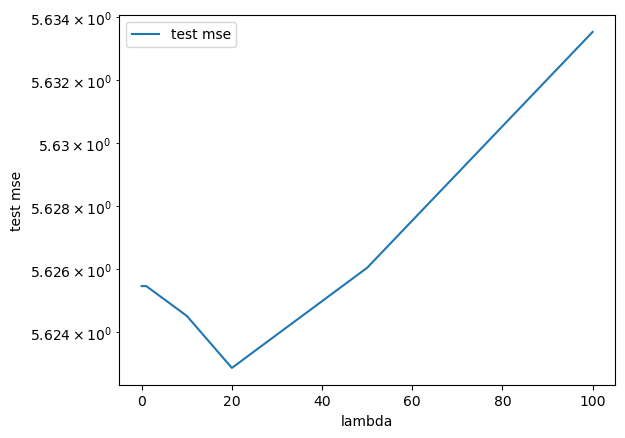

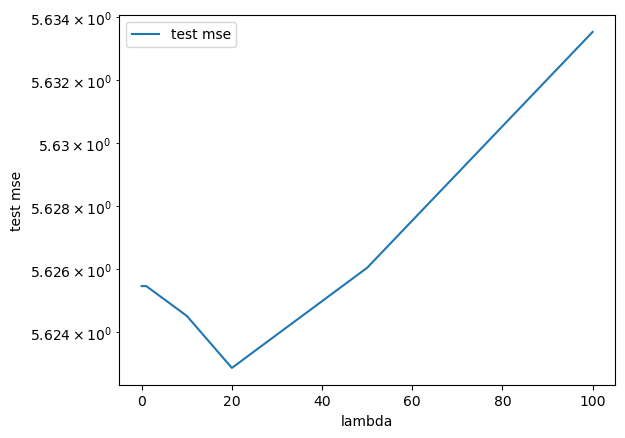

In [11]:
# Constructing the empirical risk function for LASSO regression.
def lossFunctionLASSO(theta, X, y ,Lambda):
    """
    Take in numpy array of theta, X, and y to return the regularize loss function and gradient
    of a LASSO regression
    """
    # initialize regularized average loss (empirical risk) and its gradient
    regLoss = 0
    grad = np.zeros(theta.shape)
    n = len(y)
    
    for i in range(n):
        regLoss += (y[i] - theta.T@X[i])**2
    
    regLoss *= 1/n
    regLoss += Lambda*(np.sum(np.abs(theta)))
    
    y = y.reshape(-1,1)
    
    grad = -2/n*(X.T@(y - X@theta)) + Lambda*np.sign(theta)
     
    return regLoss, grad

def gradientDescent(X,y,theta,eta,Lambda,tolerance,max_iter=1000):
    
    Loss_history =[]
    
    init_risk, init_grad = lossFunctionLASSO(theta, X, y, Lambda)
    Loss_history.append(init_risk[0])
    theta = theta - eta*init_grad
    i = 0
    
    while i < max_iter:
        risk, grad = lossFunctionLASSO(theta, X, y, Lambda)
        Loss_history.append(risk[0])
        print(risk[0])
        if np.abs(Loss_history[-2] - Loss_history[-1]) < tolerance:
            break
        theta = theta - eta*grad
        i += 1
        
    return theta, Loss_history

def train_and_eval( X_train , y_train , X_eval , y_eval , lambda_ ):
    mse = 0
    initial_theta = np.zeros((X_train.shape[1], 1))
    Eta = 1e-4
    Tolerance = 1e-3

    theta, _ = gradientDescent(X_train,y_train,initial_theta,Eta,lambda_,Tolerance)
    
    for i in range(len(y_eval)):
        mse += ((y_eval[i] - theta.flatten().T@X_eval[i]))**2
    return mse/len(y_eval)


weight_list = [1e-10, 1e-6, 1e-4, 0.01, 0.1, 1, 10, 20, 50, 100]
result_list = []

# compute test MSE
for weight in weight_list:
    test_mse = train_and_eval ( X_train , y_train , X_test , y_test , weight )
    result_list.append ([ test_mse , weight ])
    result_array = np.array ( result_list )

plt.figure()
plt.plot( result_array [: , -1] , result_array [: ,0] , label = 'test mse')
plt.xlabel('lambda')
plt.ylabel('test mse')
plt.yscale('log')
plt.legend()
plt.show()